In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

import wmfdata as wmf

You can find the source for `wmfdata` at https://github.com/neilpquinn/wmfdata


In [2]:
%matplotlib inline

mpl.rcParams["font.size"] = 16
mpl.rcParams["figure.figsize"] = (14, 7)

# Create

In [3]:
wmf.hive.run(
    """
    create table if not exists neilpquinn.new_editors(
        user_name string,
        wiki string,
        cohort string,
        1st_month_edits bigint,
        2nd_month_edits bigint
    )
    -- This allows us to delete data later on (e.g. in case of duplicate inserts)
    TBLPROPERTIES ("transactional"="true")
    """
)

# Update

In [5]:
# To-do: We take the metric month and look backwards. But this results in censored data
# for months under 30 days (February).

# Start included, end excluded. Have to set the end back a couple of months to ensure we only get uncensored data.
START = "2018-05"
END = "2018-06"

SNAPSHOT = "2018-07"

In [6]:
# Be careful not to insert duplicate data. Primary keys were introduced in Hive 2.1.0,
# so until we're running that there's no built-in way to stop duplicates.
wmf.hive.run(
    """
    insert into table neilpquinn.new_editors
    select 
        1st_month.user_name as user_name,
        1st_month.wiki as wiki,
        1st_month.cohort as cohort,
        1st_month.edits as 1st_month_edits,
        coalesce(2nd_month.edits, 0) as 2nd_month_edits
    from (
        select
            event_user_text as user_name,
            wiki_db as wiki,
            substr(event_user_creation_timestamp, 0, 7) as cohort,
            count(*) as edits
        from wmf.mediawiki_history
        where
            snapshot = "{snapshot}" and
            event_entity = "revision" and
            event_type = "create" and
            event_user_is_created_by_system = 0 and
            event_user_creation_timestamp between "{start}" and "{end}" and
            unix_timestamp(event_timestamp, "yyyy-MM-dd HH:mm:ss.0") <
                (unix_timestamp(event_user_creation_timestamp, "yyyy-MM-dd HH:mm:ss.0") + (30*24*60*60))
        group by event_user_text, event_user_creation_timestamp, wiki_db
        ) 1st_month
    left join (
        select
            event_user_text as user_name,
            wiki_db as wiki,
            substr(event_user_creation_timestamp, 0, 7) as cohort,
            count(*) as edits
        from wmf.mediawiki_history
        where
            snapshot = "{snapshot}" and
            event_entity = "revision" and
            event_type = "create" and
            event_user_is_created_by_system = 0 and
            event_user_creation_timestamp between "{start}" and "{end}" and
            unix_timestamp(event_timestamp, "yyyy-MM-dd HH:mm:ss.0") >=
                (unix_timestamp(event_user_creation_timestamp, "yyyy-MM-dd HH:mm:ss.0") + (30*24*60*60)) and
            unix_timestamp(event_timestamp, "yyyy-MM-dd HH:mm:ss.0") <
                (unix_timestamp(event_user_creation_timestamp, "yyyy-MM-dd HH:mm:ss.0") + (60*24*60*60))
            group by event_user_text, event_user_creation_timestamp, wiki_db
        ) 2nd_month
    on
        (1st_month.user_name = 2nd_month.user_name and
        1st_month.wiki = 2nd_month.wiki and
        1st_month.cohort = 2nd_month.cohort)
    """.format(
        snapshot = SNAPSHOT,
        start = START,
        end = END
    )
)

# Validate

In [7]:
# Check to make sure no cohorts have duplicated data
wikis = wmf.hive.run(
    """
    select wiki, cohort, count(*) as new_editors
    from neilpquinn.new_editors
    where wiki in ("arwiki", "enwiki", "jawiki", "zhwiki")
    group by wiki, cohort
    order by wiki, cohort asc
    limit 10000
    """
)

wikis["cohort"] = wikis["cohort"].apply(pd.to_datetime)
wikis = wikis.set_index("cohort")
wikis = wikis.pivot(columns="wiki")
wikis.columns = wikis.columns.droplevel(0)

wikis.tail()

wiki,arwiki,enwiki,jawiki,zhwiki
cohort,,,,
2018-01-01,2427.0,52937.0,3071.0,1931.0
2018-02-01,2527.0,47424.0,2849.0,1628.0
2018-03-01,2850.0,52275.0,3073.0,1827.0
2018-04-01,2870.0,48445.0,2994.0,1858.0
2018-05-01,2508.0,46217.0,3220.0,1940.0


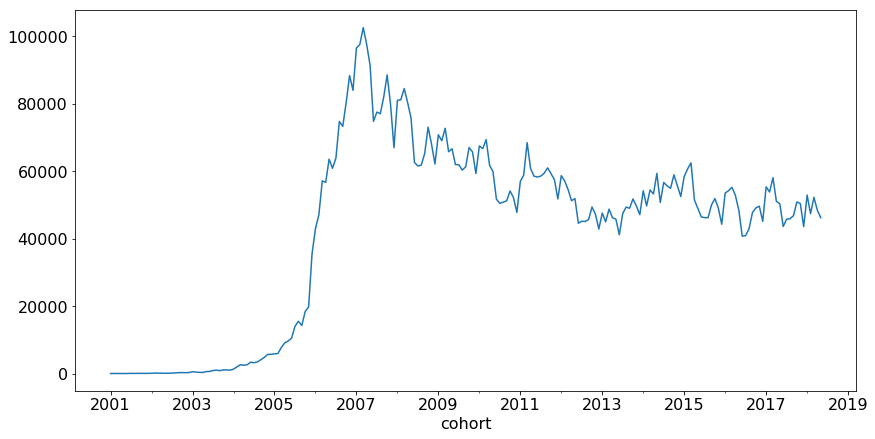

In [8]:
wikis["enwiki"].plot();

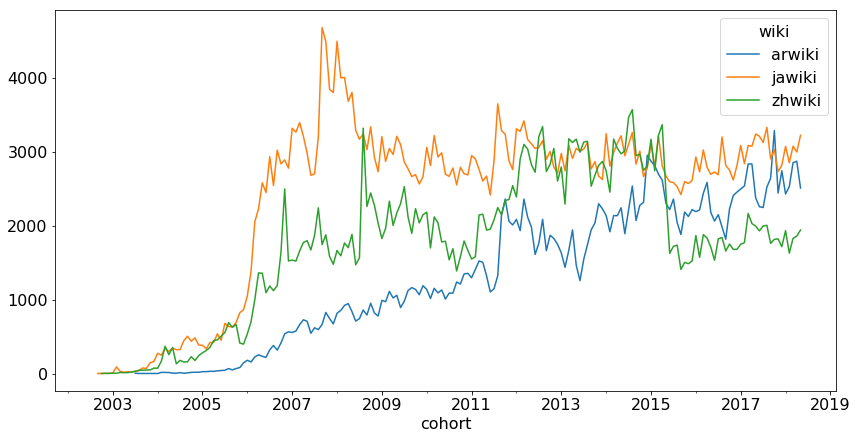

In [9]:
wikis[["arwiki", "jawiki", "zhwiki"]].plot();